# Fastai Data Augmentationi with a Style Transfer U-Net

In [1]:
from fastai import *
from fastai.vision import *

In [40]:
!pip install opencv-python>3.3.0.10

In [41]:
import cv2

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [36]:
sz = 256
bs = 32

# Dataset

In [15]:
path = Path('data/imagenet')
trn = path/'train'

In [14]:
path.ls()

[PosixPath('data/imagenet/train')]

In [18]:
data = (ImageItemList.from_folder(path)
       .random_split_by_pct()
       .label_from_folder()
       .transform(get_transforms(), size=224)
       .databunch())

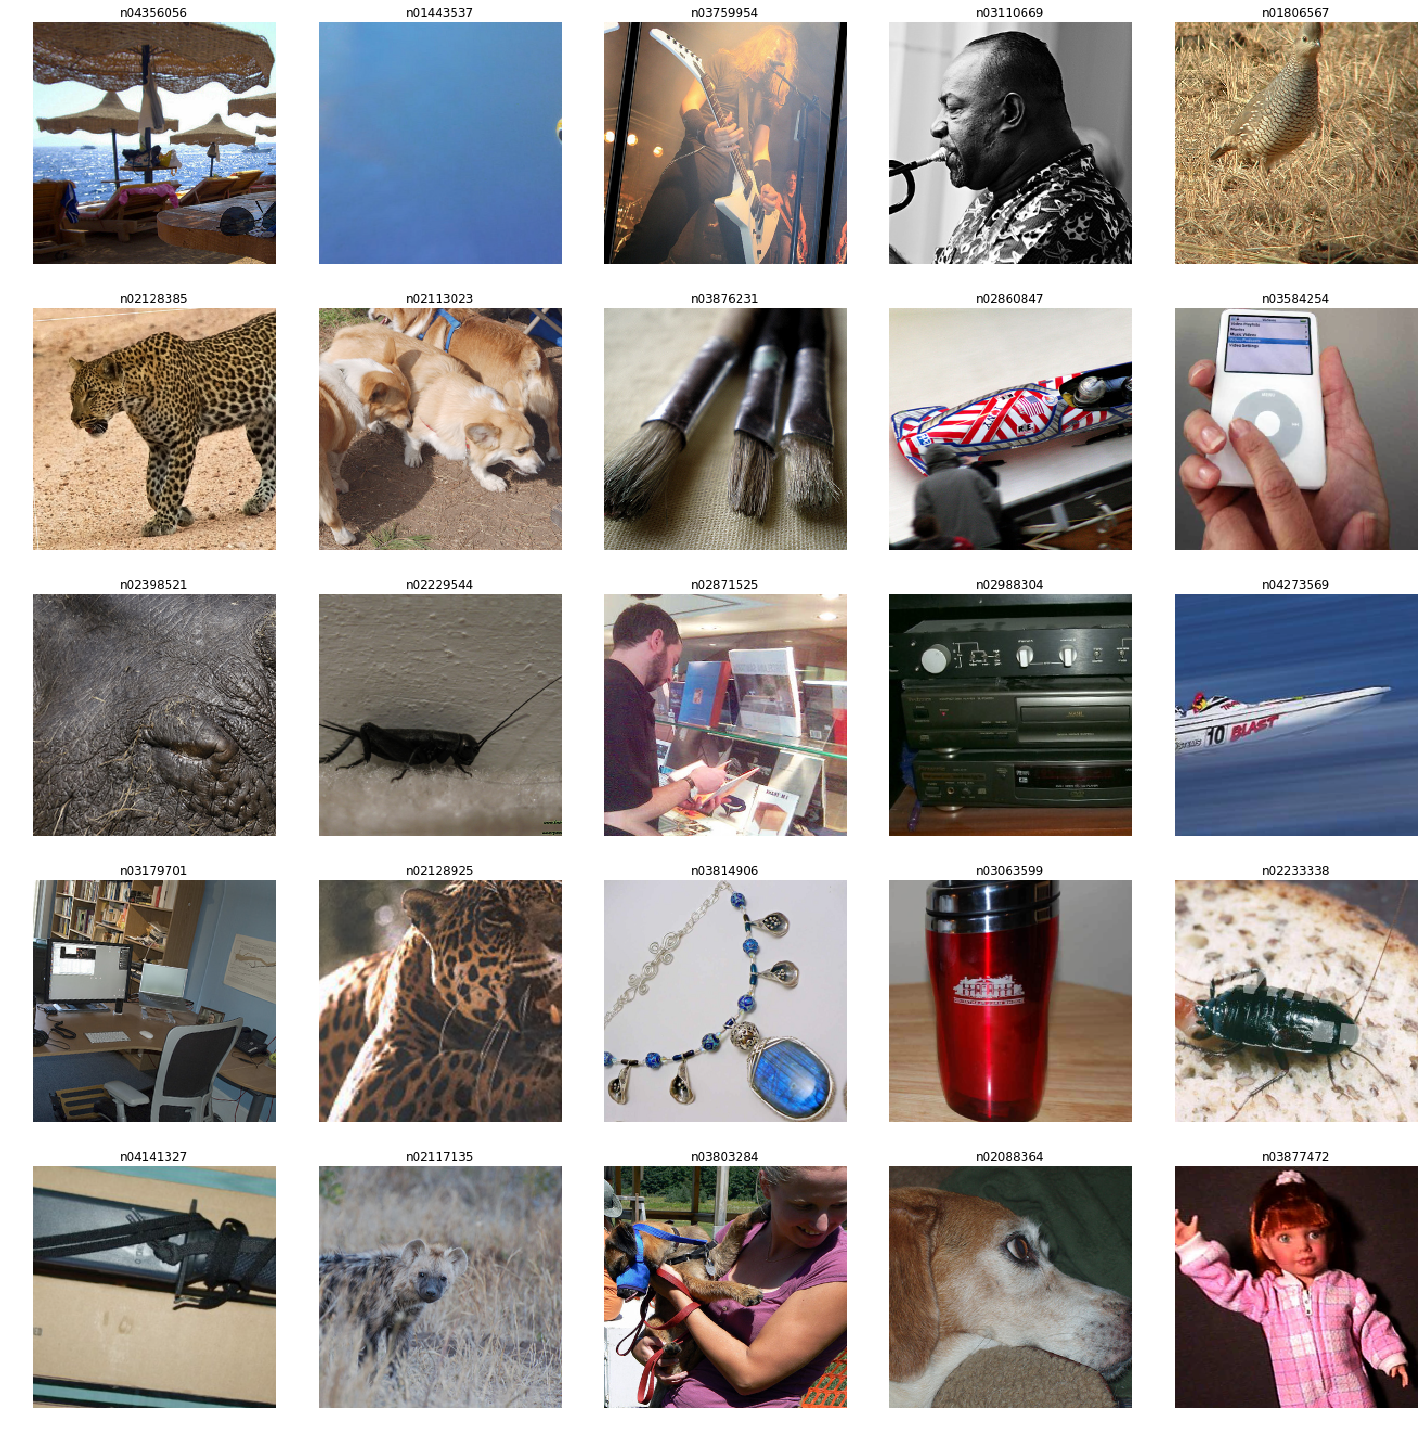

In [19]:
data.show_batch()

# Model

In [5]:
def conv(ni, nf, kernel_size=3, stride=1, actn=True, pad=None, bn=True):
    if pad is None: pad = kernel_size//2
    layers = [nn.Conv2d(ni, nf, kernel_size, stride=stride, padding=pad, bias=not bn)]
    if actn: layers.append(nn.ReLU(inplace=True))
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [9]:
class ResSequentialCenter(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.m = nn.Sequential(*layers)
        
    def forward(self, x): return x[:, :, 2:-2, 2:-2] + self.m(x)

In [71]:
def res_block(nf):
     return ResSequentialCenter([conv(nf, nf, actn=True, pad=0), conv(nf, nf, pad=0)])

In [11]:
def upsample(ni, nf):
    return nn.Sequential(nn.Upsample(scale_factor=2), conv(ni, nf))

In [12]:
class StyleResnet(nn.Module):
    def __init__(self):
        super().__init__()
        features = [nn.ReflectionPad2d(40),
                   conv(3, 32, 9),
                   conv(32, 64, stride=2),
                   conv(64, 128, stride=2)]
        # Add five res blocks to the end
        for i in range(5): features.append(res_block(128))
        features += [upsample(128, 64), upsample(64, 32), conv(32, 3, 9, actn=False)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

# Style image

In [46]:
style_pth = path/'style/eschr2.jpg'
style_img = open_image(style_pth)
style_img.shape

torch.Size([3, 570, 450])

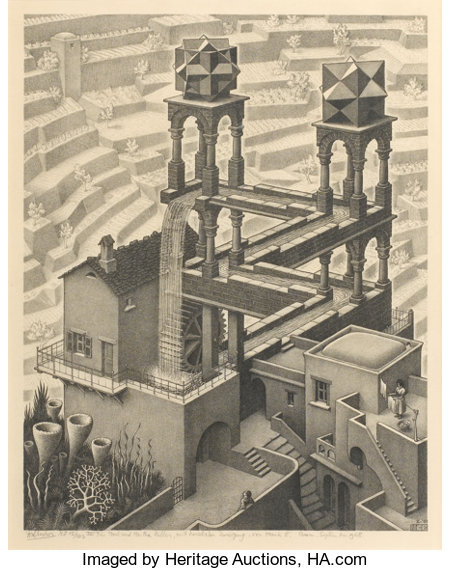

In [48]:
style_img

In [51]:
style_sized = style_img.resize(sz)

# Perceptual Loss

In [58]:
import torchvision.models as tvmodels

In [102]:
m_vgg = tvmodels.vgg16(True)
blocks = [I-1 for i,o in enumerate(children(m_vgg))
         if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks[1:]]

([], [])

In [61]:
def set_trainable_attr(m, b):
    m.trainable=b
    for p in m.parameters(): p.requires_grab=b

In [62]:
vgg_layers = children(m_vgg)[:43] # Why 43 Jeremy???
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
apply_leaf(m_vgg, lambda m: set_trainable_attr(m, False))

In [63]:
def flatten(x): return x.view(x.size(0), -1)

In [65]:
class SaveFeatures():
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [66]:
def ct_loss(input, target): return F.mse_loss(input, target)

def gram(input):
    b,c,h,w = input.size()
    x = input.view(b, c, -1)
    return torch.bmm(x, x.transpose(1,2))/(c*h*w)*1e6 # magic numbers again already??

def gram_loss(input, target):
    return F.mse_loss(gram(input), gram(target[:input.size(0)]))

In [99]:
class CombinedLoss(nn.Module):
    def __init__(self, m, layer_ids, style_im, ct_wgt, style_wgts):
        super().__init__()
        self.m, self.ct_wgt, self.style_wgts = m, ct_wgt, style_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
        # VV is variable with no gradients? saves memory basically...
        m(torch.tensor(style_im.data, requires_grad=True))
        self.style_feat = [V(o.features) for o in self.sfs]
        
    def forward(self, input, target, sum_layers=True):
        self.m(target.data.requires_grad_())
        targ_feat = self.sfs[2].features.data.clone()
        self.m(input)
        inp_feat = [o.features for o in self.sfs]
        
        res = [ct_loss(inp_feat[2], V(targ_feat)) * self.ct_wgt]
        res += [gram_loss(inp, targ)*wgt for inp, targ, wgt in zip(inp_feat, self.style_feat, self.style_wgts)]
        
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [84]:
m = StyleResnet()

In [85]:
learn = Learner(data, m, opt_func=optim.Adam)

In [101]:
learn.loss_func = CombinedLoss(m_vgg, blocks[1:], style_img, 1e4, [0.025, 0.275, 5., 0.2])

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 256, 256] instead

In [94]:
style_img.

AttributeError: 'Image' object has no attribute 'convert'